# Analysis for long-range contacts

by Pu Zheng 

2022.07.15

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

18348


In [37]:
from matplotlib.colors import LogNorm
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
plt.style.use('dark_background')

figure_master_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220729-Figures'
contact_figure_folder = os.path.join(figure_master_folder, 'LongRangeContacts')
if not os.path.exists(contact_figure_folder):
    print(f"Create contact_figure_folder: {contact_figure_folder}")
    os.makedirs(contact_figure_folder)
else:
    print(f"Use contact_figure_folder: {contact_figure_folder}")
comp_figure_folder = os.path.join(figure_master_folder, 'AB_compartments')
if not os.path.exists(comp_figure_folder):
    print(f"Create comp_figure_folder: {comp_figure_folder}")
    os.makedirs(comp_figure_folder)
else:
    print(f"Use comp_figure_folder: {comp_figure_folder}")

Create contact_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220729-Figures\LongRangeContacts
Create comp_figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220729-Figures\AB_compartments


## Load codebook

In [3]:
merged_data_folder = r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH'
print(merged_data_folder)
# 
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
print(postanalysis_folder)

\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis


In [4]:
import pandas as pd
codebook = pd.read_csv(os.path.join(merged_data_folder, 'merged_codebook_w_celltype.csv'))
bit_columns = [_n for _n in codebook.columns if 'NDB' in _n]

## Load contacts for subtypes

In [5]:
class_2_zxysDict = np.load(os.path.join(merged_data_folder, 'merged_class_2_chr_zxys.pkl'), allow_pickle=True)

# calculate overall contact prob

In [6]:
from ImageAnalysis3.structure_tools.distance import Chr2ZxysList_2_summaryDist_by_key,Chr2ZxysList_2_summaryDict

In [7]:
reload(ia.structure_tools.distance)

<module 'ImageAnalysis3.structure_tools.distance' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\structure_tools\\distance.py'>

In [8]:
subclass_2_contact_filename = os.path.join(postanalysis_folder, 'subclass_2_contactDict_600.pkl')
print(subclass_2_contact_filename)

if os.path.exists(subclass_2_contact_filename):
    subclass_2_contactDict = np.load(subclass_2_contact_filename, allow_pickle=True)
else:
    # calculate prob
    subclass_2_contactDict = {}
    for _subclass in class_2_zxysDict:
        subclass_2_contactDict[_subclass] = Chr2ZxysList_2_summaryDict(
            class_2_zxysDict[_subclass], 
            total_codebook=codebook, 
            function=ia.structure_tools.distance.contact_prob,
            num_threads=44, verbose=True)
    pickle.dump(subclass_2_contactDict, open(subclass_2_contact_filename, 'wb'))

-- preparing chr_2_zxys from 6577 cells in 0.662s.
-- summarize 231 inter-chr distances with 44 threads in 121.092s.
-- preparing chr_2_zxys from 3175 cells in 0.418s.
-- summarize 231 inter-chr distances with 44 threads in 73.766s.
-- preparing chr_2_zxys from 5700 cells in 0.787s.
-- summarize 231 inter-chr distances with 44 threads in 103.089s.
-- preparing chr_2_zxys from 3799 cells in 0.474s.
-- summarize 231 inter-chr distances with 44 threads in 75.047s.
-- preparing chr_2_zxys from 1919 cells in 0.208s.
-- summarize 231 inter-chr distances with 44 threads in 41.973s.
-- preparing chr_2_zxys from 2939 cells in 0.354s.
-- summarize 231 inter-chr distances with 44 threads in 60.138s.
-- preparing chr_2_zxys from 934 cells in 0.096s.
-- summarize 231 inter-chr distances with 44 threads in 25.623s.
-- preparing chr_2_zxys from 7911 cells in 1.305s.
-- summarize 231 inter-chr distances with 44 threads in 151.384s.
-- preparing chr_2_zxys from 2890 cells in 0.339s.
-- summarize 231 in

## ensemble average

In [8]:
all_zxys_dicts = []
for _subclass, _zxysDicts in class_2_zxysDict.items():
    all_zxys_dicts.extend(_zxysDicts)

In [9]:
reload(ia.structure_tools.distance)
from ImageAnalysis3.structure_tools.distance import Chr2ZxysList_2_summaryDist_by_key,Chr2ZxysList_2_summaryDict

In [13]:
ensemble_contactDict = Chr2ZxysList_2_summaryDict(
    all_zxys_dicts, 
    total_codebook=codebook, 
    function=ia.structure_tools.distance.contact_prob,
    parallel=True,
    num_threads=8, verbose=True) # change to 8 threads because running 44 threads directly crashed RAM

-- preparing chr_2_zxys from 54325 cells in 7.754s.
-- summarize 231 inter-chr distances with 6 threads in 9173.689s.


In [14]:
ensemble_contact_filename = os.path.join(postanalysis_folder, 'ensemble_contactDict_600.pkl')
print(ensemble_contact_filename)
pickle.dump(ensemble_contactDict, open(ensemble_contact_filename, 'wb'))

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis\ensemble_contactDict_600.pkl


In [152]:
# assemble trans-chr matrix without cis
from ImageAnalysis3.structure_tools import distance
from astropy.convolution import convolve
from sklearn.decomposition import PCA

_mat, _chr_edges, _chr_names = distance.assemble_ChrDistDict_2_Matrix(
    ensemble_contactDict, codebook, use_cis=False, use_trans=False, sort_by_region=False)
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=False)

# normalize by chr
_normed_mat = _mat.copy()
chr_2_meanContact = {}
for _chr,_inds in chr_2_indices.items():
    chr_2_meanContact[_chr] = np.nanmean(_mat[_inds])
    _normed_mat[_inds] *= 1 / chr_2_meanContact[_chr]
    _normed_mat[:,_inds] *= 1 / chr_2_meanContact[_chr]
_normed_mat = _normed_mat / np.nanmean(_normed_mat)
# correlation
_mat_df = pd.DataFrame(_normed_mat)
mat_corr_df = _mat_df.corr()

# norm corr_mat
_corr_mat = mat_corr_df.values[:-1,:-1]
_corr_mat[np.diag_indices(len(_corr_mat))] = np.nan

# gaussian blur
contact_gaussian_sigma = 0.5
_ft_corr_mat = convolve(_corr_mat, astropy.convolution.Gaussian2DKernel(contact_gaussian_sigma))
# Do PCA
# parameters used for PCA compartment calling

# PCA
contact_model = PCA(3)
contact_model.fit(_ft_corr_mat)
#p_contact_pc1_rep1 = np.reshape(contact_model.fit_transform(p_contact_corr_rep1_map), -1)
pcs = contact_model.fit_transform(_ft_corr_mat)
# normalize pc1 values
pc_vals = -1 * pcs[:,0].copy()
normed_pc_vals = pc_vals.copy()
# normalize pcval
for _chr, _inds in chr_2_indices.items():
    if _chr == 'Y':
        continue
    normed_pc_vals[_inds] = normed_pc_vals[_inds] - np.nanmean(pc_vals[_inds])
    


In [96]:
# define AB
AB_dict = {}
AB_th = -2
AB_dict['A'] = np.where(normed_pc_vals > AB_th)[0]
AB_dict['B'] = np.where(normed_pc_vals <= AB_th)[0]

<IPython.core.display.Javascript object>


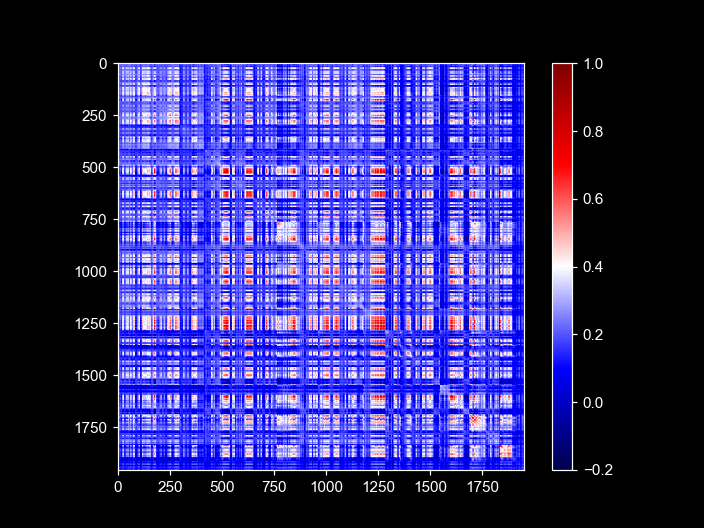

In [32]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(_ft_corr_mat, vmin=-0.2, vmax=1, cmap='seismic')
plt.colorbar(_pf)

<IPython.core.display.Javascript object>


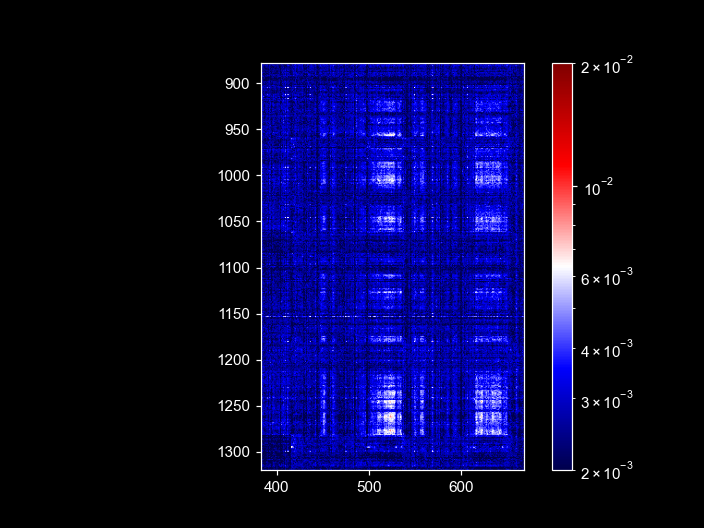

In [21]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(_mat, norm=LogNorm(vmin=2e-3, vmax=2e-2), cmap='seismic')
plt.colorbar(_pf)

<IPython.core.display.Javascript object>


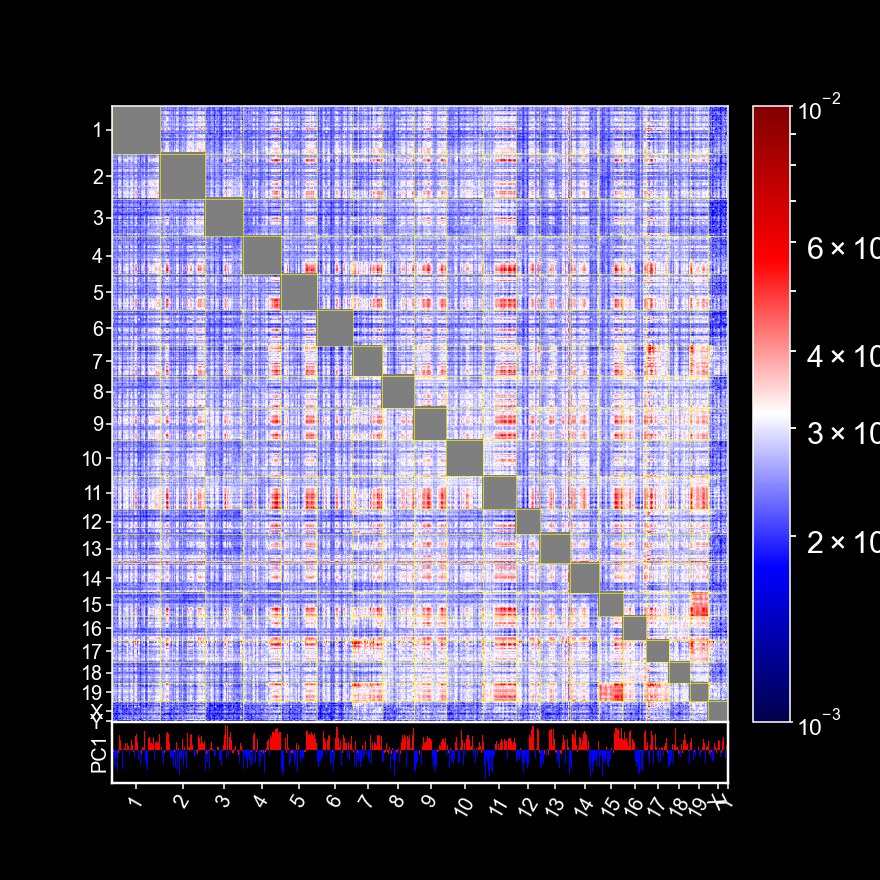

C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2915805133.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  current_cmap.set_bad(color=[0.5,0.5,0.5,1])


In [98]:
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
#plt.style.use('default')
fig, ax1 = plt.subplots(figsize=(4,4), dpi=200)

# create a color map
current_cmap = cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])



vmin,vmax = 1e-3, 1e-2

_pf = ax1.imshow(_mat, 
                 cmap=current_cmap, norm=LogNorm(vmin=vmin, vmax=vmax, ))

ax1.set_yticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
ax1.set_yticklabels(_chr_names,)

#                                              ticks=
#                                              tick_labels=_chr_names,

ax1.hlines(_chr_edges-0.5, 0, len(_mat), color='yellow', linewidth=0.2)
ax1.vlines(_chr_edges-0.5, 0, len(_mat), color='yellow', linewidth=0.2)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([0, len(_mat)])
ax1.set_ylim([len(_mat), 0])

ax1.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[vmin,vmax])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
#bot_ax.bar(AB_dict['A'], height=1, color='r', width=1, label='A')
#bot_ax.bar(AB_dict['B'], height=-1, color='b', width=1, label='B')
bot_ax.bar(AB_dict['A'], normed_pc_vals[AB_dict['A']], color='r',width=1, bottom=AB_th)
bot_ax.bar(AB_dict['B'], normed_pc_vals[AB_dict['B']], color='b',width=1, bottom=AB_th)

bot_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
bot_ax.set_xticklabels(_chr_names, rotation=60)
bot_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.tick_params('y', labelsize=_font_size-1, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.set_ylabel('PC1', fontsize=_font_size-1, labelpad=1)
#bot_ax.set_ylim([-10,10])
#bot_ax.set_yticks([0.5,-0.5])
#bot_ax.set_yticklabels(["A","B"])
fig.savefig(os.path.join(comp_figure_folder, f"trans_contact_AB.png"),
            transparent=True)

In [99]:
# save
AB_dict

{'A': array([   4,    9,   13, ..., 1952, 1953, 1954], dtype=int64),
 'B': array([   0,    1,    2,    3,    5,    6,    7,    8,   10,   11,   12,
          14,   16,   17,   18,   19,   28,   29,   31,   32,   33,   34,
          35,   43,   54,   55,   56,   57,   65,   67,   70,   71,   81,
          82,   83,   84,   85,   88,   89,   90,   91,   92,  106,  107,
         108,  109,  110,  111,  112,  113,  134,  158,  160,  161,  162,
         163,  164,  170,  183,  184,  185,  186,  187,  188,  189,  190,
         191,  192,  193,  194,  195,  196,  199,  200,  201,  202,  203,
         207,  212,  213,  214,  215,  216,  217,  220,  221,  222,  226,
         227,  228,  229,  231,  232,  233,  234,  235,  236,  256,  260,
         261,  262,  263,  264,  265,  296,  297,  298,  300,  301,  302,
         303,  304,  305,  307,  308,  309,  325,  326,  327,  328,  341,
         342,  343,  344,  346,  347,  348,  349,  351,  363,  364,  369,
         381,  387,  391,  394,  399, 

In [ ]:
_normed_mat = _mat.copy()
chr_2_meanContact = {}
for _chr,_inds in chr_2_indices.items():
    chr_2_meanContact[_chr] = np.nanmean(_mat[_inds])
    _normed_mat[_inds] *= 1 / chr_2_meanContact[_chr]
    _normed_mat[:,_inds] *= 1 / chr_2_meanContact[_chr]
_normed_mat = _normed_mat / np.nanmean(_normed_mat)

pc_vals = -1 * pcs[:,0].copy()
normed_pc_vals = pc_vals.copy()
# normalize pcval
for _chr, _inds in chr_2_indices.items():
    if _chr == 'Y':
        continue
    normed_pc_vals[_inds] = normed_pc_vals[_inds] - np.nanmean(pc_vals[_inds])
normed_pc_vals = normed_pc_vals / np.std(normed_pc_vals)


In [195]:
subclass_2_normedMat = {}
subclass_2_corrMat = {}
subclass_2_normedPC1 = {}

for _subclass, _contactDict in subclass_2_contactDict.items():
    print(_subclass)
    # assemble matrix based on codebook
    _subclass_mat, _, _ = distance.assemble_ChrDistDict_2_Matrix(
        _contactDict, codebook, use_cis=False, use_trans=False, sort_by_region=False)
    # normalize subclass_mat
    _normed_subclass_mat = _subclass_mat.copy()
    chr_2_meanContact = {}
    for _chr,_inds in chr_2_indices.items():
        chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])
        _normed_subclass_mat[_inds] *= 1 / chr_2_meanContact[_chr]
        _normed_subclass_mat[:,_inds] *= 1 / chr_2_meanContact[_chr]
    _normed_subclass_mat = _normed_subclass_mat / np.nanmean(_normed_subclass_mat)
    # merge the normed mat
    _merged_normed_mat = np.concatenate([_normed_mat, _normed_subclass_mat]).transpose()
    # correlation
    _merged_mat_corr_df = pd.DataFrame(_merged_normed_mat).corr()
    # norm corr_mat
    _merged_corr_mat = _merged_mat_corr_df.values
    _merged_corr_mat[np.diag_indices(len(_merged_corr_mat))] = np.nan
    #
    _sel_sub_corr_mat = _merged_corr_mat[1956:,:1956][:-1,:-1]
    _ft_sub_corr_mat = convolve(_sel_sub_corr_mat, astropy.convolution.Gaussian2DKernel(contact_gaussian_sigma))
    # calculate PC
    sub_pcs = contact_model.fit_transform(_ft_sub_corr_mat)

    # normalize pc1 values
    sub_pc_vals = sub_pcs[:,0].copy()
    normed_sub_pc_vals = sub_pc_vals.copy()
    # normalize pcval
    for _chr, _inds in chr_2_indices.items():
        if _chr == 'Y':
            continue
        normed_sub_pc_vals[_inds] = normed_sub_pc_vals[_inds] - np.nanmean(sub_pc_vals[_inds])
    normed_sub_pc_vals = normed_sub_pc_vals / np.std(normed_sub_pc_vals)
    # append
    subclass_2_normedMat[_subclass] = _normed_subclass_mat
    subclass_2_corrMat[_subclass] = _ft_sub_corr_mat
    subclass_2_normedPC1[_subclass] = normed_sub_pc_vals

Astro


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Endo-PVM


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L2/3 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L4/5 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5 ET


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L5/6 NP


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6 CT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6 IT


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


L6b


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Lamp5


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Micro


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


OPC


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Oligo


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Peri


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Pvalb


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


SMC
Sncg


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Sst


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


VLMC


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


Vip


C:\Users\puzheng\AppData\Local\Temp\2/ipykernel_18348/2380886079.py:14: RuntimeWarning: Mean of empty slice
  chr_2_meanContact[_chr] = np.nanmean(_subclass_mat[_inds])


<IPython.core.display.Javascript object>


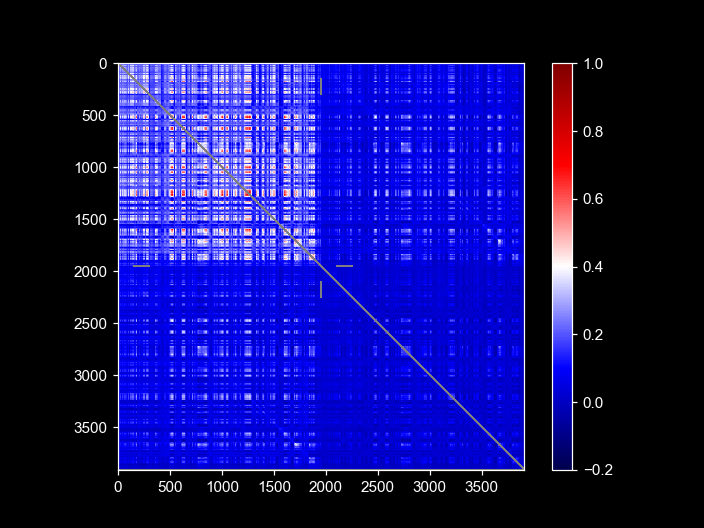

In [168]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(_merged_corr_mat, vmin=-0.2, vmax=1, cmap='seismic')
plt.colorbar(_pf)

In [203]:
test_AB_th = -0.5
ens_A = np.where(normed_pc_vals >= test_AB_th)[0]
ens_B = np.where(normed_pc_vals < test_AB_th)[0]

sub_A = np.where(normed_sub_pc_vals >= test_AB_th)[0]

In [304]:
subclass_2_selfNormedPC1 = {}
for _subclass, _ft_sub_corr_mat in subclass_2_corrMat.items():
    # PCA
    #print(_subclass, np.max(_ft_sub_corr_mat))
    _subclass_model = PCA(3)
    _subclass_model.fit(_ft_sub_corr_mat)
    #_sub_pcs = _subclass_model.fit_transform(_ft_sub_corr_mat.transpose())
    _sub_pcs = _subclass_model.fit_transform(_ft_sub_corr_mat)
    # normalize pc1 values
    sub_pc_vals = _sub_pcs[:,0].copy() 
    normed_sub_pc_vals = sub_pc_vals.copy()
    # normalize pcval
    for _chr, _inds in chr_2_indices.items():
        if _chr == 'Y':
            continue
        normed_sub_pc_vals[_inds] = normed_sub_pc_vals[_inds] - np.nanmean(sub_pc_vals[_inds])
    normed_sub_pc_vals = normed_sub_pc_vals / np.std(normed_sub_pc_vals)
    # append
    subclass_2_selfNormedPC1[_subclass] = normed_sub_pc_vals
    


<IPython.core.display.Javascript object>


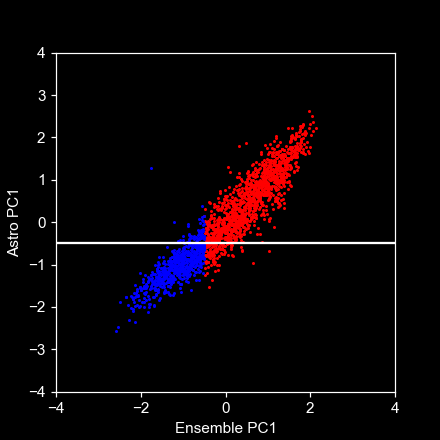

In [303]:
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
ax.scatter(normed_pc_vals[ens_A], normed_sub_pc_vals[ens_A], s=1, c='r')
ax.scatter(normed_pc_vals[ens_B], normed_sub_pc_vals[ens_B], s=1, c='b')
ax.set_xlabel('Ensemble PC1')
ax.set_ylabel(f"{_subclass} PC1")
ax.set_ylim([-4,4])
ax.set_xlim([-4,4])
ax.hlines(test_AB_th, -4,4)
ax.set_aspect('equal')
fig.show()

<IPython.core.display.Javascript object>


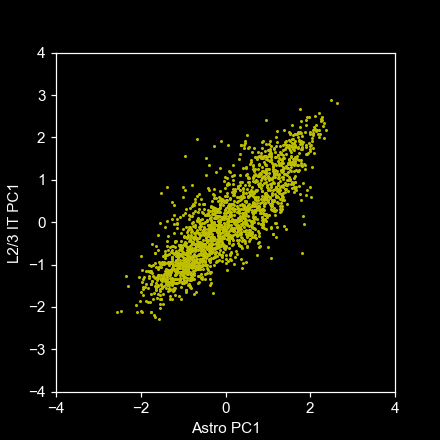

In [325]:
subclass_1 = 'Astro'
subclass_2 = 'L2/3 IT'

fig,ax = plt.subplots(figsize=(4,4),dpi=100)
ax.scatter(subclass_2_normedPC1[subclass_1], subclass_2_normedPC1[subclass_2], s=1, c='y')
ax.set_xlabel(f"{subclass_1} PC1")
ax.set_ylabel(f"{subclass_2} PC1")

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])
ax.set_aspect('equal')
fig.show()

<IPython.core.display.Javascript object>


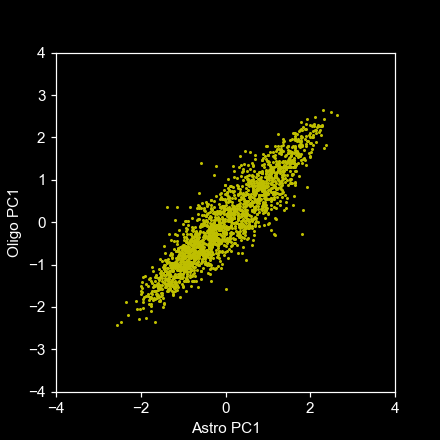

In [332]:
subclass_1 = 'Astro'
subclass_2 = 'Oligo'

fig,ax = plt.subplots(figsize=(4,4),dpi=100)
ax.scatter(subclass_2_normedPC1[subclass_1], subclass_2_normedPC1[subclass_2], s=1, c='y')
ax.set_xlabel(f"{subclass_1} PC1")
ax.set_ylabel(f"{subclass_2} PC1")

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])
ax.set_aspect('equal')
fig.show()

<IPython.core.display.Javascript object>


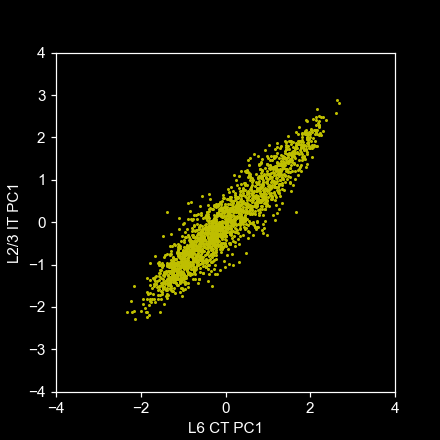

In [329]:
subclass_1 = 'L6 CT'
subclass_2 = 'L2/3 IT'

fig,ax = plt.subplots(figsize=(4,4),dpi=100)
ax.scatter(subclass_2_normedPC1[subclass_1], subclass_2_normedPC1[subclass_2], s=1, c='y')
ax.set_xlabel(f"{subclass_1} PC1")
ax.set_ylabel(f"{subclass_2} PC1")

ax.set_ylim([-4,4])
ax.set_xlim([-4,4])
ax.set_aspect('equal')
fig.show()

In [297]:
np.min(subclass_2_selfNormedPC1['Astro'] - subclass_2_normedPC1['Astro'])

-3.4416913763379853e-15

<IPython.core.display.Javascript object>


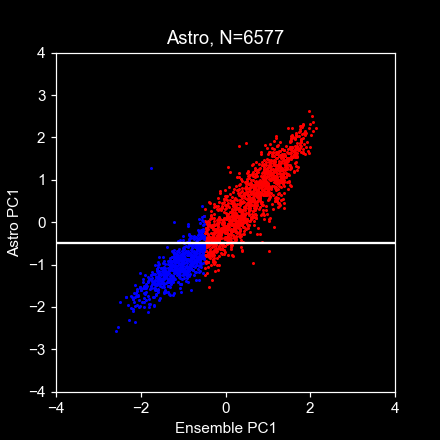

<IPython.core.display.Javascript object>


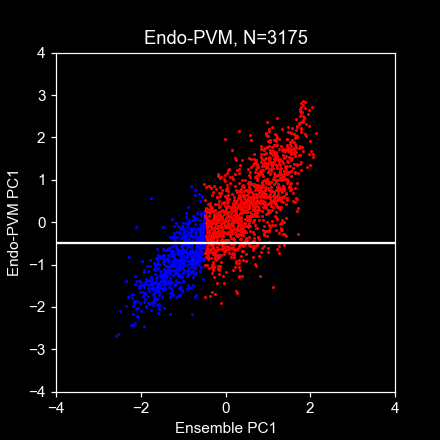

<IPython.core.display.Javascript object>


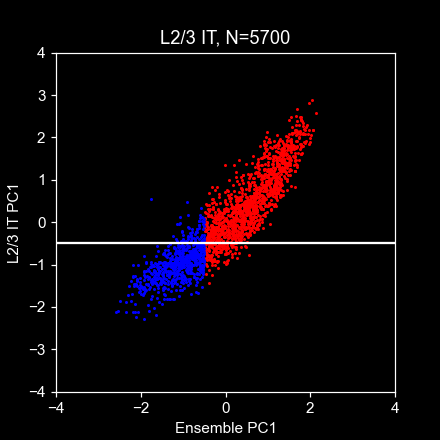

<IPython.core.display.Javascript object>


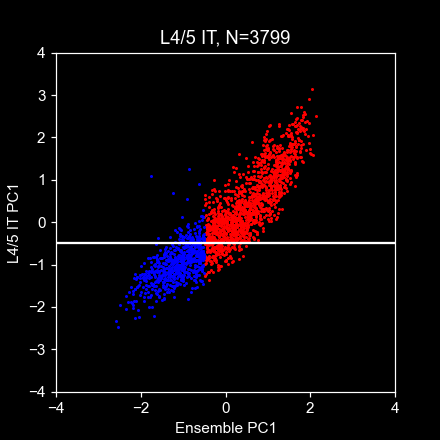

<IPython.core.display.Javascript object>


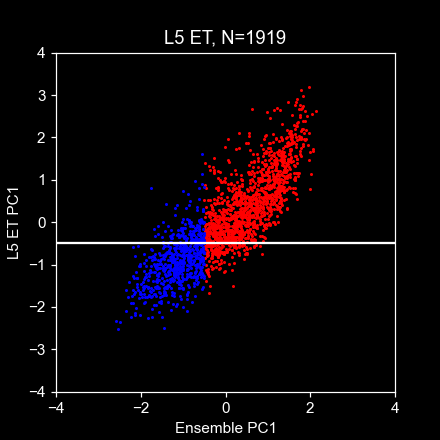

<IPython.core.display.Javascript object>


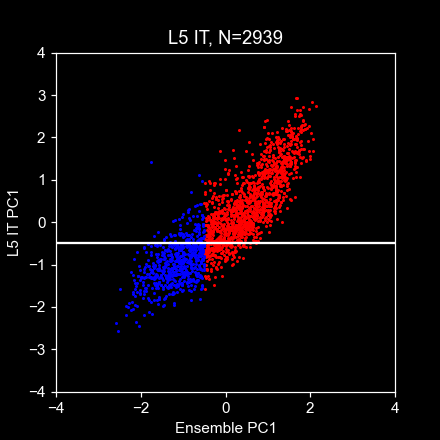

<IPython.core.display.Javascript object>


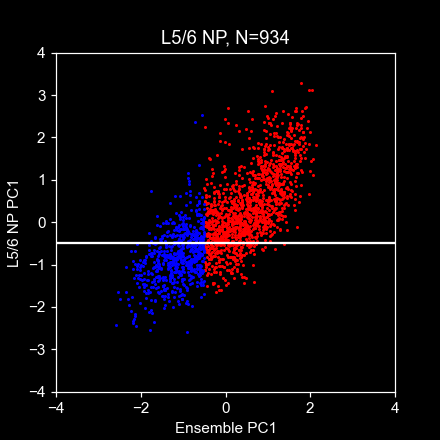

<IPython.core.display.Javascript object>


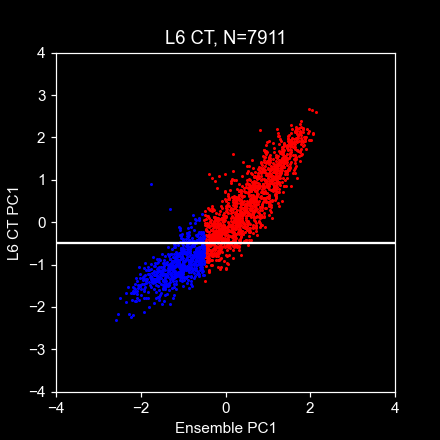

<IPython.core.display.Javascript object>


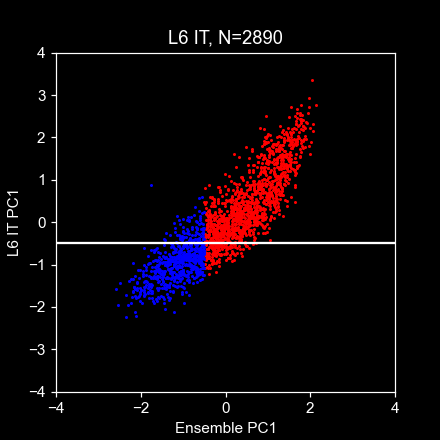

<IPython.core.display.Javascript object>


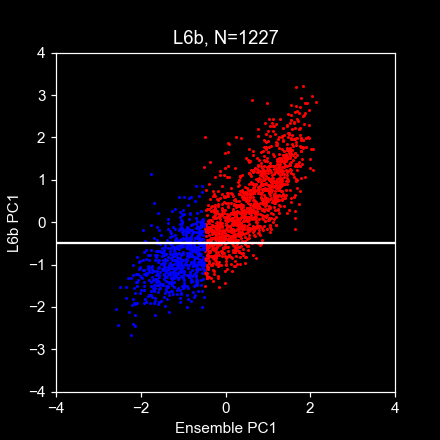

<IPython.core.display.Javascript object>


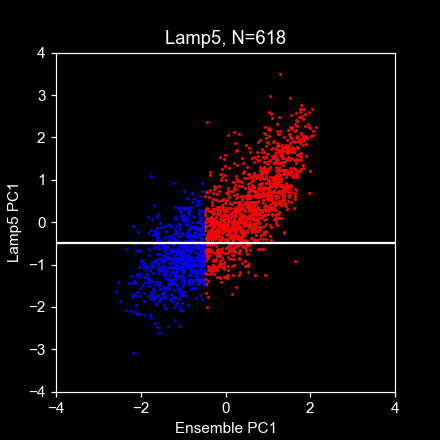

<IPython.core.display.Javascript object>


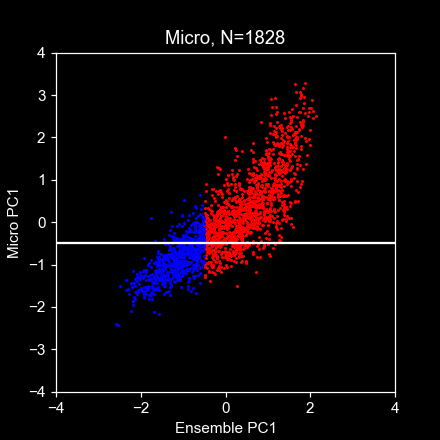

<IPython.core.display.Javascript object>


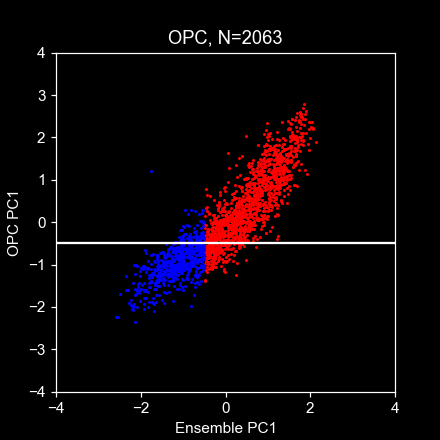

<IPython.core.display.Javascript object>


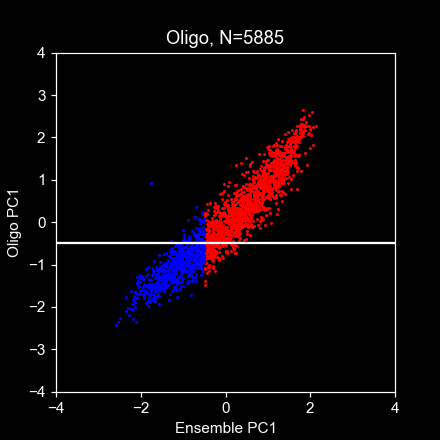

<IPython.core.display.Javascript object>


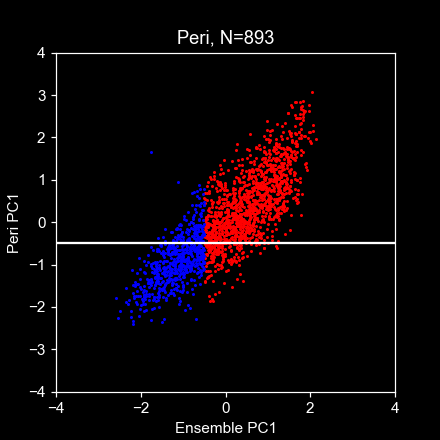

<IPython.core.display.Javascript object>


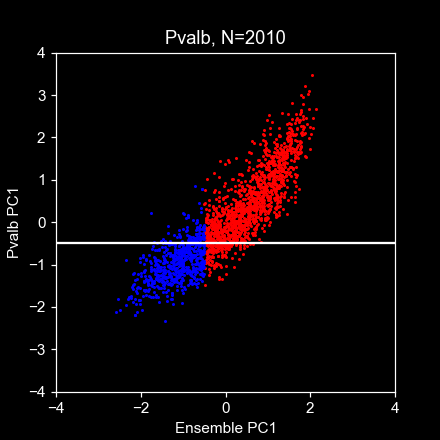

<IPython.core.display.Javascript object>


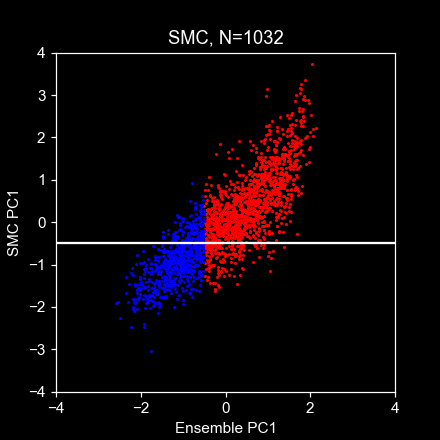

<IPython.core.display.Javascript object>


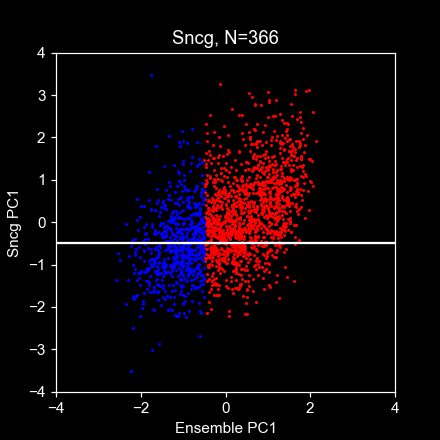

<IPython.core.display.Javascript object>


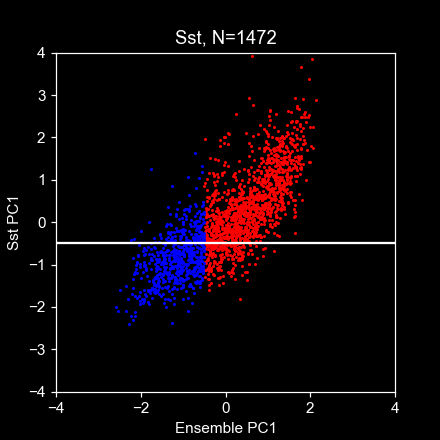

<IPython.core.display.Javascript object>


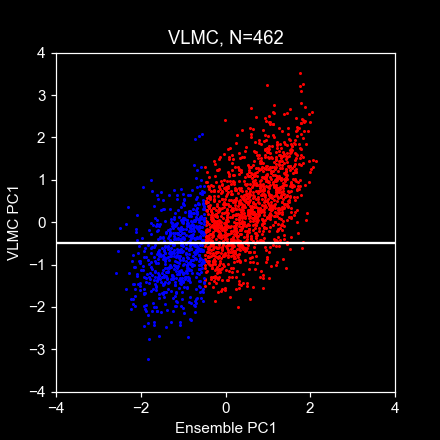

<IPython.core.display.Javascript object>


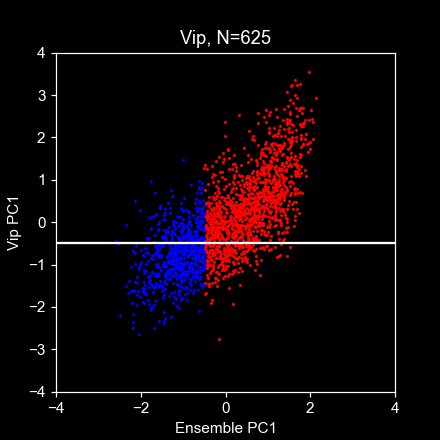

In [248]:
#sel_subclass = 'Astro'
for sel_subclass in subclass_2_normedPC1:
    fig,ax = plt.subplots(figsize=(4,4),dpi=100)
    ax.scatter(normed_pc_vals[ens_A], subclass_2_normedPC1[sel_subclass][ens_A], s=1, c='r')
    ax.scatter(normed_pc_vals[ens_B], subclass_2_normedPC1[sel_subclass][ens_B], s=1, c='b')
    ax.set_xlabel('Ensemble PC1')
    ax.set_ylabel(f"{sel_subclass} PC1")
    ax.set_ylim([-4,4])
    ax.set_xlim([-4,4])
    ax.hlines(test_AB_th, -4,4)
    ax.set_aspect('equal')
    ax.set_title(f"{sel_subclass}, N={len(class_2_zxysDict[sel_subclass])}")
    fig.show()

In [273]:
for _subclass in class_2_zxysDict:
    print(_subclass, len(class_2_zxysDict[_subclass]))

Astro 6577
Endo-PVM 3175
L2/3 IT 5700
L4/5 IT 3799
L5 ET 1919
L5 IT 2939
L5/6 NP 934
L6 CT 7911
L6 IT 2890
L6b 1227
Lamp5 618
Micro 1828
OPC 2063
Oligo 5885
Peri 893
Pvalb 2010
SMC 1032
Sncg 366
Sst 1472
VLMC 462
Vip 625


In [307]:
subclass_2_normedPC1['ensemble'] = normed_pc_vals

(764, 959)

<IPython.core.display.Javascript object>


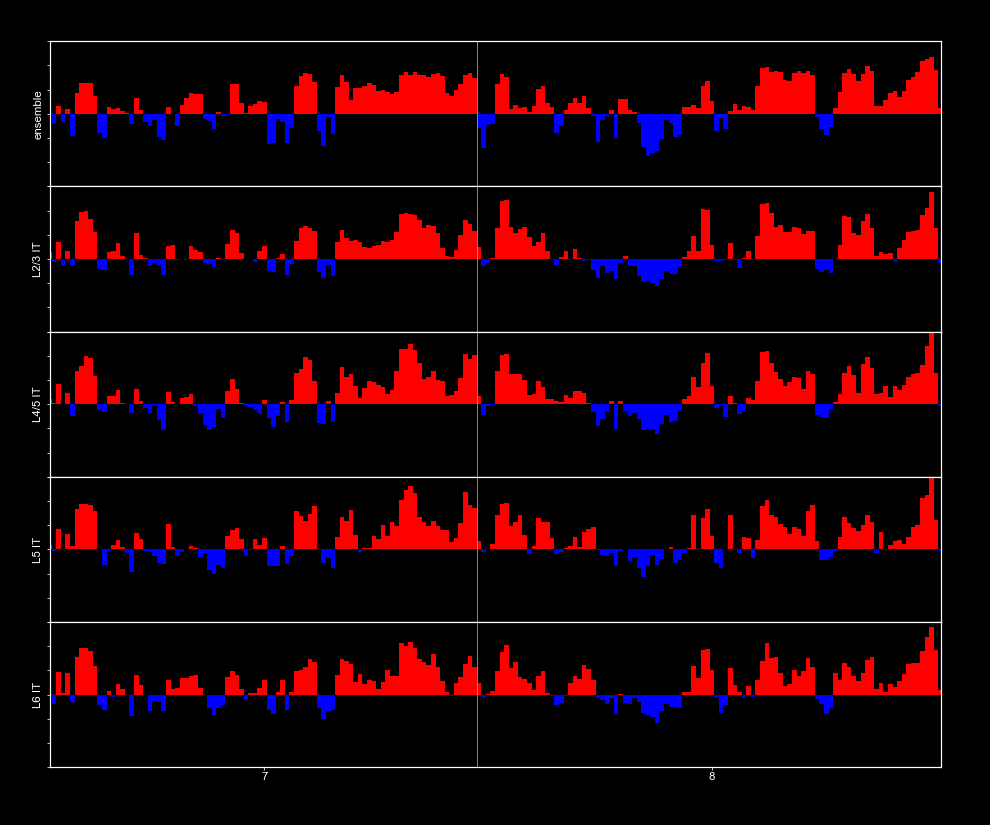

In [321]:
#nonNeu_subclasses = ['Oligo','Astro','Endo-PVM','Micro', 'OPC']
#nonNeu_subclasses = ['Oligo','Astro','L2/3 IT', 'L5 ET']
ITNeu_subclasses = ["ensemble", "L2/3 IT", 'L4/5 IT', 'L5 IT', 'L6 IT']
im_size = 1.5
_font_size = 7.5
sel_subclasses = ITNeu_subclasses

num_x = len(sel_subclasses)
fig, axes = plt.subplots(num_x, 1, figsize=(im_size*6,num_x*im_size), 
                         sharex=True, sharey=True, dpi=100)
for _i, _subclass in enumerate(sel_subclasses):
    _normedPC1 = subclass_2_normedPC1[_subclass]
    _ax = axes[_i]
    _ax.vlines(_chr_edges-0.5, -3, 3, color='y', linewidth=0.5)
    _subclass_A = np.where(_normedPC1 >= test_AB_th)[0]
    _subclass_B = np.where(_normedPC1 < test_AB_th)[0]
    # bar
    _ax.bar(_subclass_A, _normedPC1[_subclass_A]-test_AB_th, color='r',width=1, bottom=0)
    _ax.bar(_subclass_B, _normedPC1[_subclass_B]-test_AB_th, color='b',width=1, bottom=0)
    _ax.set_ylabel(f"{_subclass}", fontsize=_font_size)
    _ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, ) # remove bottom ticklabels for ax1
# set axes
_ax.set_ylim([-3,3])
_ax.set_xlim([-0.5, len(_mat)+0.5])
_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
_ax.set_xticklabels(_chr_names,)

_ax.set_xlim([chr_2_indices['7'].min(), chr_2_indices['8'].max()])

fig.subplots_adjust(wspace=0.2, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.07)
fig.show()

<IPython.core.display.Javascript object>


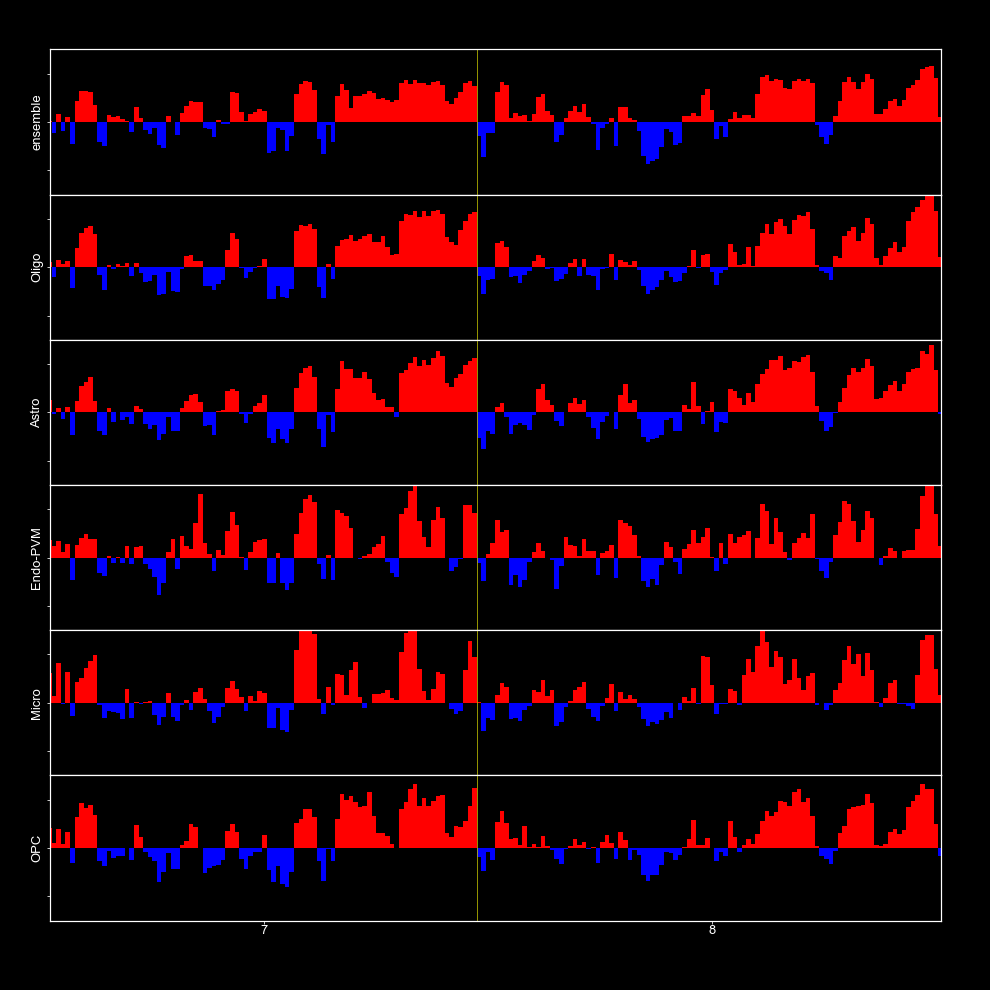

In [323]:
nonNeu_subclasses = ["ensemble", 'Oligo','Astro','Endo-PVM','Micro', 'OPC']

#ITNeu_subclasses = ["ensemble", "L2/3 IT", 'L4/5 IT', 'L5 IT', 'L6 IT']
im_size = 1.5
_font_size = 7.5
sel_subclasses = nonNeu_subclasses

num_x = len(sel_subclasses)
fig, axes = plt.subplots(num_x, 1, figsize=(im_size*6,num_x*im_size), 
                         sharex=True, sharey=True, dpi=100)
for _i, _subclass in enumerate(sel_subclasses):
    _normedPC1 = subclass_2_normedPC1[_subclass]
    _ax = axes[_i]
    _ax.vlines(_chr_edges-0.5, -3, 3, color='y', linewidth=0.5)
    _subclass_A = np.where(_normedPC1 >= test_AB_th)[0]
    _subclass_B = np.where(_normedPC1 < test_AB_th)[0]
    # bar
    _ax.bar(_subclass_A, _normedPC1[_subclass_A]-test_AB_th, color='r',width=1, bottom=0)
    _ax.bar(_subclass_B, _normedPC1[_subclass_B]-test_AB_th, color='b',width=1, bottom=0)
    _ax.set_ylabel(f"{_subclass}", fontsize=_font_size+1)
    _ax.tick_params('both', labelsize=_font_size+1, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    labelleft=False,
                    pad=1, ) # remove bottom ticklabels for ax1
# set axes
_ax.set_ylim([-3,3])
_ax.set_xlim([-0.5, len(_mat)+0.5])
_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])/2,)
_ax.set_xticklabels(_chr_names,)

_ax.set_xlim([chr_2_indices['7'].min(), chr_2_indices['8'].max()])

fig.subplots_adjust(wspace=0.2, hspace=0., left=0.05, right=0.95, top=0.95, bottom=0.07)
fig.show()

<IPython.core.display.Javascript object>


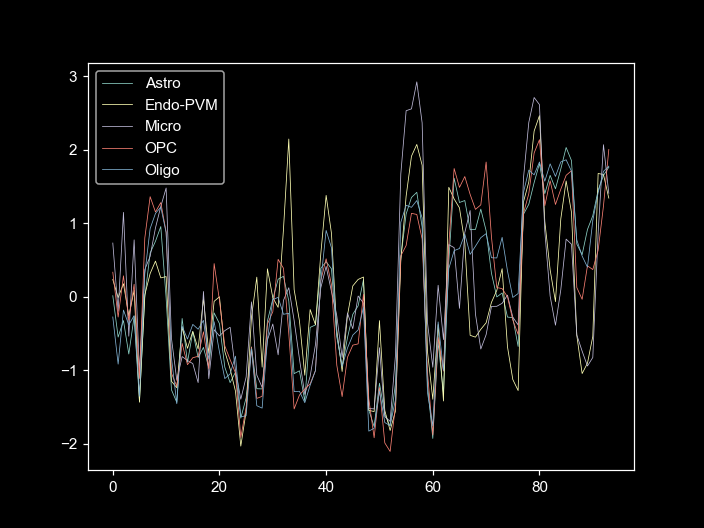

In [232]:
_diff_AB_vectors = {}
fig,ax = plt.subplots()

for _subclass, _normedPC1 in subclass_2_normedPC1.items():
    _vec = np.zeros_like(_normedPC1)
    _vec[np.intersect1d(np.where(_normedPC1>=test_AB_th)[0], ens_B)] = 1
    _vec[np.intersect1d(np.where(_normedPC1<test_AB_th)[0], ens_A)] = -1
    _diff_AB_vectors[_subclass] = _vec
    #if 'IT' in _subclass:
        #ax.plot(_vec[chr_2_indices['1']], label=f'{_subclass}')
        #ax.plot(_normedPC1[chr_2_indices['7']], label=f'{_subclass}', linewidth=0.5)
    if _subclass in nonNeu_subclasses:
        ax.plot(_normedPC1[chr_2_indices['7']], label=f'{_subclass}', linewidth=0.5)
ax.legend()
fig.show()

In [ ]:
plt.figure()


<IPython.core.display.Javascript object>


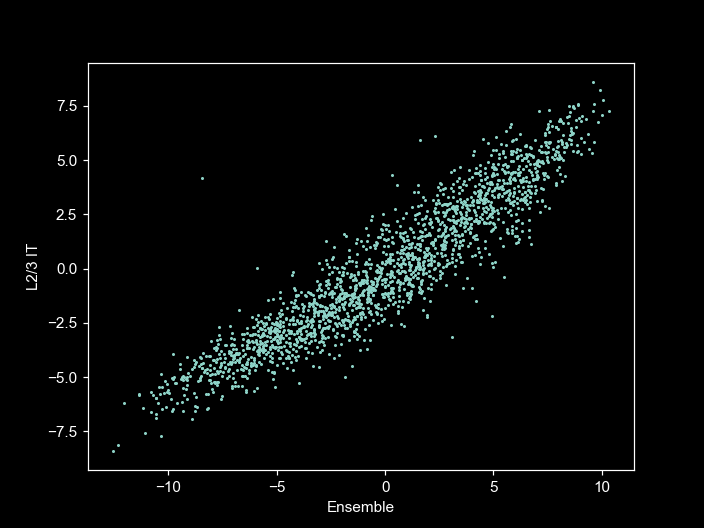

<IPython.core.display.Javascript object>


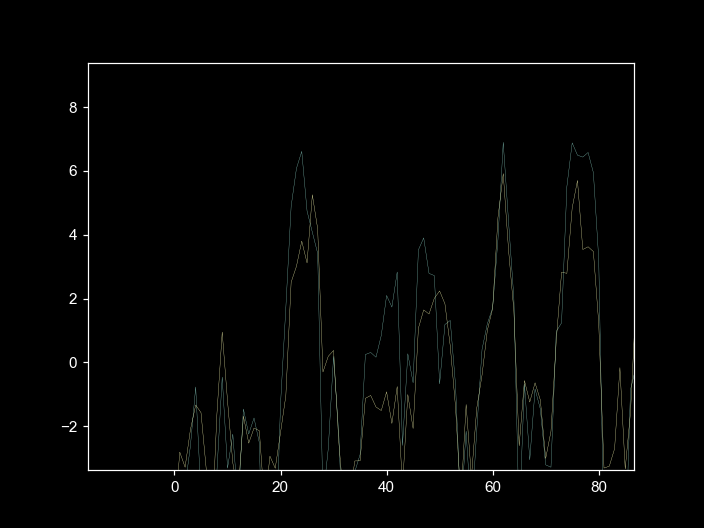

In [166]:
fig,ax = plt.subplots()
ax.scatter(normed_pc_vals, normed_sub_pc_vals, s=1)
ax.set_xlabel('Ensemble PC1')
ax.set_ylabel(f"{_subclass} PC1")
fig.show()
fig,ax = plt.subplots()
ax.plot(normed_pc_vals,linewidth=0.2)
ax.plot(normed_sub_pc_vals,linewidth=0.2)
fig.show()

In [192]:
ens_A

(1311,)

In [190]:
np.intersect1d(ens_A, sub_A).shape

(1182,)

In [ ]:
_ft_corr_mat

In [183]:
contact_ratio = []
_AB_ths = np.arange(-1, 0, 0.05)
for _AB_th in _AB_ths:
    AB_dict = {}
    AB_dict['A'] = np.where(normed_pc_vals > _AB_th)[0]
    AB_dict['B'] = np.where(normed_pc_vals <= _AB_th)[0]
    
    _AA_contacts = _normed_mat[AB_dict['A'],AB_dict['A'][:,np.newaxis]]
    _BB_contacts = _normed_mat[AB_dict['B'],AB_dict['B'][:,np.newaxis]]
    _AB_contacts = _normed_mat[AB_dict['A'],AB_dict['B'][:,np.newaxis]]
    print(_AB_th, len(_AA_contacts), len(_BB_contacts), np.nanmedian(_AA_contacts), np.nanmedian(_AB_contacts), np.nanmedian(_BB_contacts))
    #contact_ratio.append(np.nanmedian(_AA_contacts) * np.nanmedian(_BB_contacts) / np.nanmedian(_AB_contacts)**2)
    contact_ratio.append(np.nanmedian(_AA_contacts) / np.nanmedian(_BB_contacts))

-1.0 1579 376 1.0427897977633829 0.85736465241872 0.8384544429681022
-0.95 1561 394 1.0465654195562564 0.8593581412817537 0.8392371956706346
-0.8999999999999999 1538 417 1.0503148131229791 0.8633214093039989 0.8427326917041194
-0.8499999999999999 1510 445 1.055366837691694 0.867391290361138 0.8448042465574537
-0.7999999999999998 1481 474 1.0608806000134992 0.871497268797922 0.8485249760814744
-0.7499999999999998 1462 493 1.0646413339426184 0.8741479427778404 0.8492589535235716
-0.6999999999999997 1436 519 1.0699970571263688 0.8773256264774338 0.8512130810282912
-0.6499999999999997 1408 547 1.075738333342865 0.8809832427883144 0.8529039892961052
-0.5999999999999996 1377 578 1.0810824233186933 0.8852437230946428 0.8569984970483105
-0.5499999999999996 1346 609 1.0865476043045295 0.8898556369626663 0.8594657707703047
-0.49999999999999956 1311 644 1.0940230993757674 0.8937530504073852 0.8628443678639011
-0.4499999999999995 1284 671 1.0986474544013893 0.8976355623379331 0.8652411165865592
-0

<IPython.core.display.Javascript object>


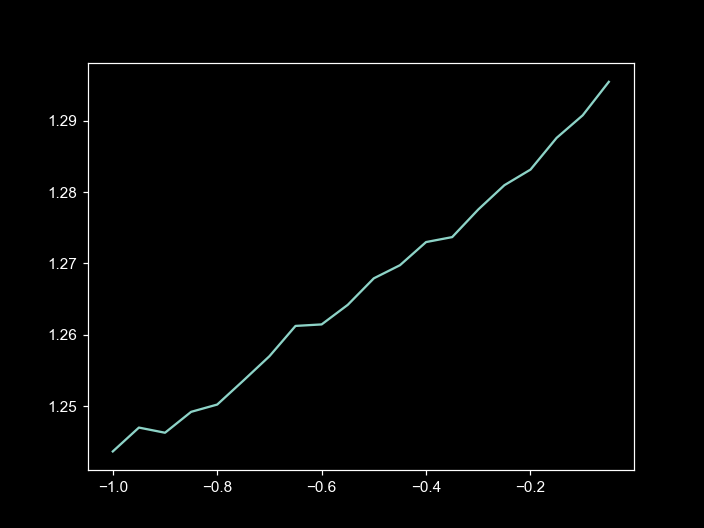

In [184]:
fig, ax = plt.subplots()
ax.plot(_AB_ths, contact_ratio)

<IPython.core.display.Javascript object>


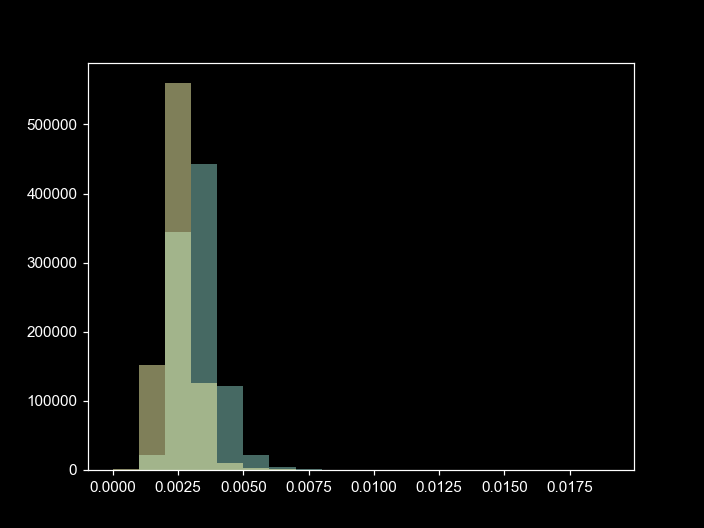

(array([1.00400e+03, 1.51662e+05, 5.60346e+05, 1.25222e+05, 1.02580e+04,
        2.07800e+03, 7.42000e+02, 3.28000e+02, 2.00000e+02, 1.28000e+02,
        8.20000e+01, 6.20000e+01, 2.20000e+01, 2.80000e+01, 1.40000e+01,
        1.00000e+01, 2.00000e+00, 6.00000e+00, 0.00000e+00]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019]),
 <BarContainer object of 19 artists>)

In [64]:
fig, ax = plt.subplots()
ax.hist(_AA_contacts[np.isfinite(_AA_contacts)], bins=np.arange(0,0.02, 0.001),alpha=0.5)
ax.hist(_BB_contacts[np.isfinite(_BB_contacts)], bins=np.arange(0,0.02, 0.001),alpha=0.5)


<IPython.core.display.Javascript object>


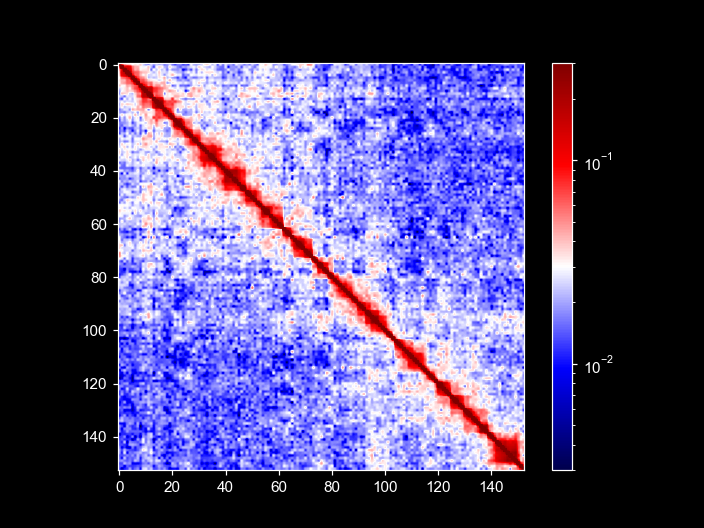

In [15]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(subclass_2_contactDict['L2/3 IT'][('cis_1')], norm=LogNorm(vmin=3e-3, vmax=3e-1), cmap='seismic')
plt.colorbar(_pf)

<IPython.core.display.Javascript object>


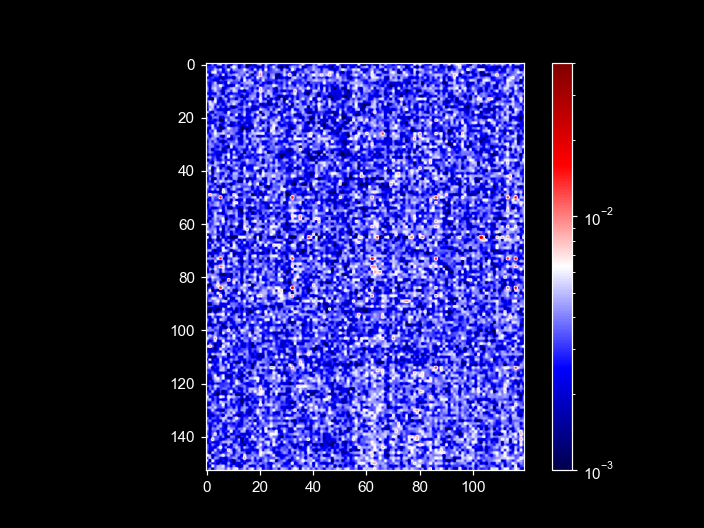

In [45]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
_pf = ax.imshow(subclass_2_contactDict['Astro'][('1', '3')], norm=LogNorm(vmin=1e-3, vmax=4e-2), cmap='seismic')
plt.colorbar(_pf)

dict_keys(['Astro', 'Endo-PVM', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'])

In [169]:
contact_dict = np.load(r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH\0402plus0316_major_4class_2_summary_dict_nonnan100_contact600',
                    allow_pickle=True)
count_dict = np.load(r'\\crick\SSD_0\Shiwei\DNA_MERFISH_analysis\20220402plus0316_MERFISH\0402plus0316_major_4class_2_len.pkl',
                    allow_pickle=True)

In [218]:
class_2_zxysDict = pickle.load(open(r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0\class_2_chr_zxys_n18723.pkl', 'rb'))

In [221]:
class_2_zxysDict.keys()

dict_keys(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'])

In [7]:
contact_dict.keys()

dict_keys(['Astro', 'Oligo', 'Gluta', 'GABA'])

<IPython.core.display.Javascript object>


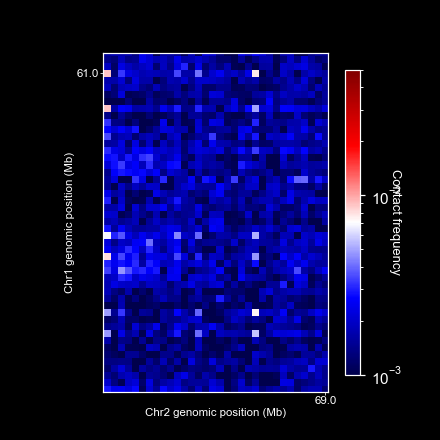

meta NOT subset; don't know how to subset; dropped


In [8]:
_key = 'Gluta'
sel_feature = ('1', '2')
vmin=1e-3
vmax=5e-2
c1, c2 = sel_feature

c1_codebook = codebook.loc[codebook['chr']==str(c1)].sort_values('chr_order')
c2_codebook = codebook.loc[codebook['chr']==str(c2)].sort_values('chr_order')

c1_ticks = np.arange(0, len(c1_codebook), 50)
c2_ticks = np.arange(0, len(c2_codebook), 50)
c1_starts = np.round([int(_name.split(':')[1].split('-')[0])/1e6 for _name in c1_codebook['name'] ])
c2_starts = np.round([int(_name.split(':')[1].split('-')[0])/1e6 for _name in c2_codebook['name'] ])


fig, _ax = plt.subplots(figsize=(4,4), dpi=100)

_contact_mat = contact_dict[_key][sel_feature]
_pf = _ax.imshow(_contact_mat, cmap='seismic', norm=LogNorm(vmin=vmin, vmax=vmax))
# get ticks
_ax.set_yticks(c1_ticks)
_ax.set_yticklabels(c1_starts[c1_ticks])
_ax.set_ylabel(f"Chr{c1} genomic position (Mb)", fontsize=_font_size, labelpad=1)
_ax.set_xticks(c2_ticks)
_ax.set_xticklabels(c2_starts[c2_ticks])
_ax.set_xlabel(f"Chr{c2} genomic position (Mb)", fontsize=_font_size, labelpad=1)
_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, ) # remove bottom ticklabels for ax1

cbar = plt.colorbar(_pf, ax=_ax, shrink=0.9)
cbar.set_label('Contact frequency', 
               fontsize=_font_size+1, labelpad=0, rotation=270)

fig.savefig(os.path.join(contact_figure_folder, f'contact_{c1}_{c2}_{_key}.pdf'), transparent=True, dpi=300)
fig.savefig(os.path.join(contact_figure_folder, f'contact_{c1}_{c2}_{_key}.png'), transparent=True, dpi=300)
plt.show()

In [69]:
def get_2d_neighbors(ix, iy, array, neighbor_radius=1):
    """t"""
    _coords = np.array(np.meshgrid(np.arange(ix-neighbor_radius,ix+neighbor_radius+1), 
                         np.arange(iy-neighbor_radius,iy+neighbor_radius+1))).reshape(2,-1)
    _coords = _coords[:,np.where((_coords[0] != ix ) + (_coords[1] != iy ))[0]] # exclude itself
    _vals = ndimage.map_coordinates(array, _coords, mode='constant', cval=np.nan)
    _vals = _vals[np.isfinite(_vals)]
    return _vals

50 73 2.192285549798503 0.02887406428282007 0.06044905008635579
50 84 2.740962417610663 0.01987491814231791 0.053720601465107314
50 87 1.9246461282264773 0.02117664720956982 0.042464612822647796
55 76 1.6739826893463368 0.018661737052398365 0.0306033948705241
73 50 2.1922855497985028 0.028874064282820074 0.06044905008635579
73 84 1.6439534106562115 0.03098201505714075 0.05223777192739366
73 114 1.7608815366916202 0.019474894345682645 0.033128506545551696
76 55 1.6739826893463365 0.01866173705239837 0.0306033948705241
84 50 2.740962417610663 0.01987491814231791 0.053720601465107314
84 73 1.643953410656212 0.030982015057140745 0.05223777192739366
87 50 1.9246461282264777 0.02117664720956982 0.042464612822647796
114 73 1.7608815366916195 0.01947489434568265 0.033128506545551696


In [ ]:
longrange_calling

C:\Users\puzheng\AppData\Local\Temp\ipykernel_16192\4210283463.py:11: RuntimeWarning: divide by zero encountered in log
  peak_map = np.log(_contact_mat / ndimage.convolve(_contact_mat, mean_kernel, mode='nearest')) / np.log(2)


0 38 1.3502925877763325 2.3422323219328987 0.005635023840485479
0 84 1.2385488447507091 2.68602294312026 0.006080259424402107
1 11 1.4244451200972943 4.016877556794849 0.006587615283267457
1 30 1.4251968503937005 3.5558655364259075 0.005249343832020997
1 75 1.3641799282494704 3.139319147524355 0.00643915003219575
2 19 1.4685570409447872 3.9878526348672554 0.007133864876206463
2 39 1.2178805876836512 2.8118372912934357 0.00700218818380744
2 47 1.4581907090464543 3.679008229055267 0.006845965770171149
2 49 1.4583538689009357 3.8509397968922556 0.006407097092163627
2 51 1.3085521885521882 2.4888599853040865 0.005925925925925926
2 62 1.5388865278368038 3.7764169562986973 0.006374840628984276
2 72 1.3965744400527003 3.110009018646274 0.00644122383252818
2 77 1.1646010530579176 2.930860955308311 0.0044552450384771165
2 80 1.26171875 3.7491324205165455 0.00625
2 85 1.281967213114754 2.587400456242094 0.006557377049180328
2 116 1.4392216551765302 4.343979878379081 0.011161846778285134
2 120 1.

49 84 1.2726445152480652 2.461120822978615 0.005917159763313609
50 1 1.6468318221070806 4.233608860581352 0.008095854922279792
50 16 1.6133037991676735 3.7797475670186786 0.008860249697946033
50 19 2.8711983161701338 9.42433039834782 0.01928211213289825
50 29 1.1909677419354836 2.254354789392856 0.008602150537634409
50 32 1.587100050787201 3.924892929934064 0.008633824276282377
50 34 1.2373158756137477 2.8222954411521304 0.00851063829787234
50 40 2.3597507281717807 9.85521322687189 0.015647226173541962
50 44 1.351838134430727 3.81015495627338 0.00850480109739369
50 47 1.4252980698279538 3.1357186954602385 0.006990562740300594
50 49 1.3779540047581282 3.2220131196499135 0.006185567010309278
50 54 1.552064909798372 4.623112049011127 0.010214007782101167
50 66 1.7156342182890854 4.7118594468751755 0.007079646017699115
50 68 2.438122332859175 8.50944857392713 0.008534850640113799
50 82 1.251589825119237 2.6544660039079044 0.006756756756756757
50 106 3.7459839728202646 19.210988338547754 0.

87 109 0.8848890898705253 2.005240726309458 0.008758568164508759
87 119 2.2584867789510423 7.186950125049683 0.009773976786805132
87 127 1.2377701647438155 2.8205250648892823 0.009559675550405562
87 128 0.8079044304699108 1.5325391956674428 0.007723304231027535
87 138 1.612273361227336 4.779747846288918 0.009483960948396096
87 141 1.2400781536207102 3.332787252745516 0.0069605568445475635
88 46 1.3279306972195053 3.6797987275070283 0.007125890736342043
88 88 0.8721770380177793 1.564841944527237 0.00707395498392283
89 4 1.3341478313989001 2.6637662718162916 0.004886988393402566
89 40 1.3515492297780116 3.497706326520184 0.006852925672113864
89 49 1.0321530321530317 1.8680259531648964 0.004884004884004884
89 68 2.104206940992359 7.188185648863348 0.009113504556752278
89 92 1.487525792534233 5.3619763866711585 0.007315700619020821
90 90 1.360603653693407 4.022931766481784 0.007148530579825258
91 16 1.4333727810650883 3.51599539802444 0.008205128205128205
91 24 1.3390688259109313 3.7433783

<IPython.core.display.Javascript object>


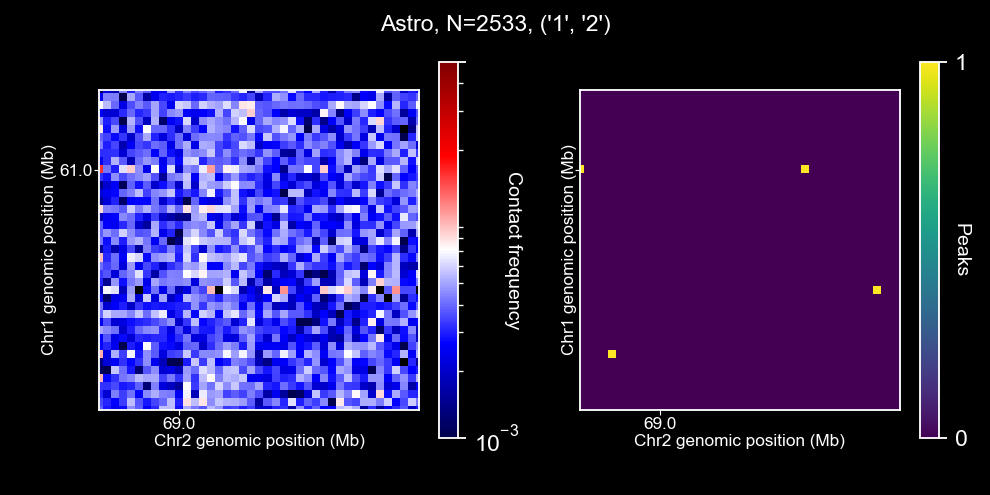

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220711-Figures\LongRangeContacts\LongRangeContact_Astro_1-2.png
6 25 1.6930422008547004 5.9015228241481115 0.004340277777777778
13 107 1.6579949238578675 7.982703276231446 0.005393401015228426
16 75 1.6936997319034852 6.702647617659069 0.006367292225201072
22 16 1.737325504352395 7.354275042665147 0.008544860517718019
22 51 1.7397959183673462 6.4035374886861 0.007320319432120674
26 19 1.4854285097503053 3.6690604998612866 0.0078578110383536
26 88 1.5888888888888884 5.063570397121825 0.00785024154589372
26 106 1.7812499999999991 8.142118995410701 0.008838383838383838
26 119 1.760510240747395 5.3797148619664155 0.007716920760399021
42 19 1.573158191528178 4.5223764503955035 0.009918068132815868
42 114 1.7557682866961213 6.227521309539245 0.005645557191948944
42 116 1.4761014686248326 4.892975780652618 0.006408544726301735
44 88 1.6601372212692969 6.538728737338168 0.007169811320754717
46 66 1.190672963400236 2.3651083442630534 0.00413223140

<IPython.core.display.Javascript object>


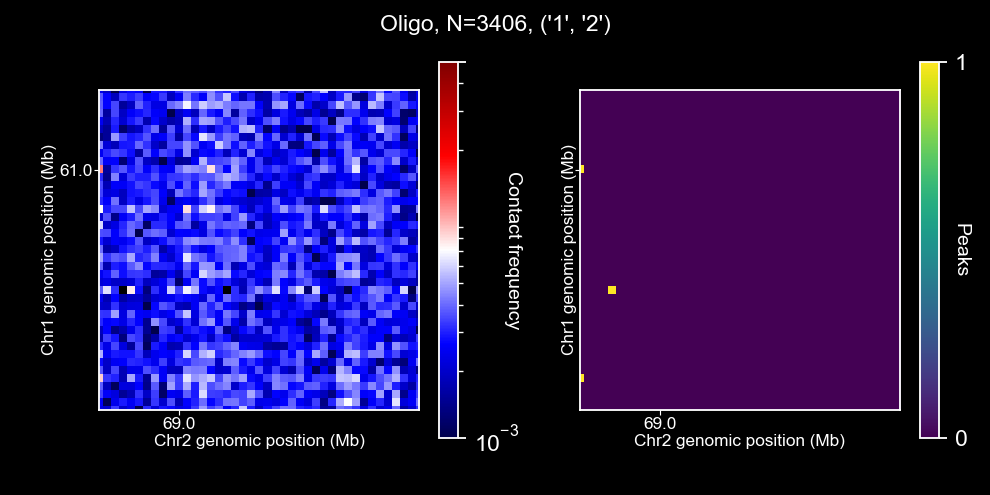

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220711-Figures\LongRangeContacts\LongRangeContact_Oligo_1-2.png
2 19 1.688394403730846 5.07186472102409 0.0035443037974683543
2 40 2.2413518185937997 9.127712917208225 0.0027274710888064587
2 114 1.4457420050305425 3.3953520197830547 0.0032339202299676607
4 122 1.8636885667894332 5.7134727917942065 0.003762227238525207
8 19 2.3401020740579863 8.949081145369517 0.006515365403409708
8 32 1.5182935432893103 3.980318430390425 0.0034710463934981375
8 40 1.9007315650105463 5.890674763857917 0.0034872761545711593
8 106 2.1848271341962966 9.007003462547438 0.004833688349991807
18 19 1.9426538818434889 6.122509190904352 0.003196205794411795
18 127 1.9876540673788001 9.210391325122746 0.0029580936729663105
22 16 1.9575975780383073 7.545093346896021 0.007852077001013171
22 40 1.6106332925566953 4.436961864598074 0.003481697562811706
22 127 2.354939880008169 9.836381053008196 0.009193137979151276
26 19 2.3312804294452993 11.465836292507634 0.00640838

<IPython.core.display.Javascript object>


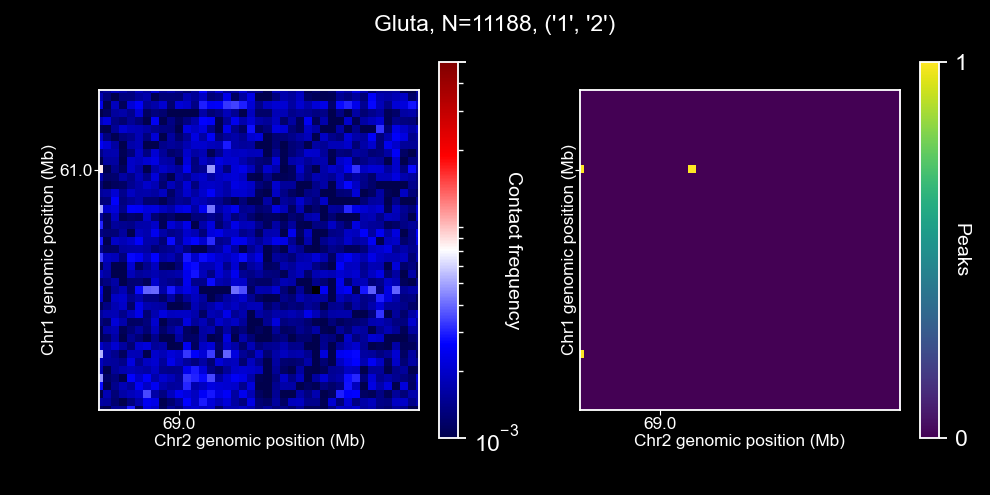

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220711-Figures\LongRangeContacts\LongRangeContact_Gluta_1-2.png
0 24 1.459580838323353 2.95410961800642 0.0029940119760479044
0 27 2.138408304498269 5.117866075165444 0.0034602076124567475
0 49 1.6489655172413789 4.014071505400874 0.002758620689655172
0 78 1.3304812834224597 2.8229769328869834 0.0030557677616501145
0 90 1.752760441670667 4.27079152710097 0.0028804608737397984
1 44 1.127167630057803 2.170729274165757 0.0026678523788350376
1 70 1.244517319122771 3.1088906911851084 0.003825920612147298
1 122 1.2192667145938167 2.362398228253609 0.002875629043853343
2 18 1.2934537246049662 3.1378043649806924 0.005079006772009029
2 23 1.1320109439124486 2.136604815156163 0.003419972640218878
2 28 1.5564053537284892 4.247799145219398 0.0038240917782026767
2 63 1.1802388707926166 2.494487117189976 0.0027144408251900108
2 75 1.6182070356827642 5.113929866792918 0.00529567519858782
2 99 1.6946778711484598 4.041925725272592 0.006127450980392157
2 1

32 44 1.6525925925925924 5.58196811823018 0.0044444444444444444
32 58 1.3191928671984983 2.863710572597626 0.003754106053496011
32 116 0.919354838709677 2.0141022605884333 0.0033370411568409346
33 15 1.1707707707707704 2.248917635014413 0.0024024024024024023
33 107 1.7770169322709155 4.399006819353392 0.0034860557768924302
33 125 0.9825870646766167 2.2978053465492607 0.0024875621890547263
34 21 1.4386882129277565 2.9878398816253937 0.0042775665399239545
34 39 1.2697536945812804 2.0991872726705476 0.002955665024630542
34 56 1.2387349566190873 2.7569595976490007 0.0033585222502099076
34 65 0.9582527401676335 1.7302883081955878 0.0024177949709864605
34 67 1.2743837084673093 2.048940893232271 0.003215434083601286
34 88 1.4189189189189186 2.5775461195947926 0.0033783783783783786
34 100 1.6489663558978507 3.219251394714607 0.0032428050263477908
34 102 1.018986296846624 1.9612537768626992 0.001981178801386825
34 118 1.1186069167072574 1.9493644876084761 0.0014612761811982464
35 5 1.4024064171

68 42 1.8601494716948712 4.859485091998545 0.005411906193625977
68 48 1.0187760778859523 1.9849960554780404 0.0034770514603616135
68 66 1.7154639175257729 5.836487883446977 0.004123711340206186
68 84 1.5633314700950252 3.434786649361066 0.004471771939631079
68 102 1.132630410654828 2.772540376413072 0.004439511653718091
68 127 1.6016909347111319 3.933769416397053 0.004697040864255519
68 135 1.1781001309559784 2.750508394642611 0.004533091568449683
69 72 1.2982093663911847 2.3971791163259595 0.0027548209366391185
69 74 1.0354515050167221 1.9855869703020368 0.004459308807134894
69 80 1.4956848552338524 2.6696945765467417 0.0038975501113585748
70 28 1.422355090516525 3.1445049481487044 0.003986048829098156
70 46 1.092314118629908 2.117747560309869 0.003132832080200501
70 57 1.1080305523905976 2.4150158358612415 0.004177744018230156
70 67 2.28101802757158 5.102500353801434 0.004772004241781549
70 88 1.4575353871773518 3.863318015350034 0.004995836802664446
70 91 1.685213086526043 3.5737287

99 73 1.1085028690662486 2.0670434615239355 0.0020865936358894104
99 115 1.3119834710743796 2.6559717158547342 0.0027548209366391185
99 133 1.6899907321594065 3.8370734730616194 0.003243744207599629
100 31 0.7914551607445007 1.6911363493493325 0.00338409475465313
100 38 1.6012721129000187 3.384768212331572 0.002385211687537269
100 64 1.030936819172113 2.0796227639698706 0.002178649237472767
100 70 1.1250381213784693 2.4239535066598488 0.003202195791399817
100 84 1.4169491525423725 3.31410182942884 0.0030816640986132513
100 88 2.0553154710458075 4.747149019020554 0.005185825410544511
100 102 1.0368314833501513 2.640746012387107 0.0030272452068617556
100 110 1.2464911326297456 2.601381331741074 0.004188880426504189
100 117 1.2138044823319123 2.7271688338399795 0.0038498556304138597
100 122 1.6852718360071293 3.170794785516083 0.004679144385026738
101 42 2.0903732809430253 4.38332979546518 0.00343811394891945
101 60 1.4045045045045044 2.9315612313356634 0.002702702702702703
101 79 1.61353

142 109 1.2712673611111112 3.050610412798041 0.003472222222222222
144 40 1.8436606291706386 4.302060845080089 0.004766444232602479
144 92 2.0214852872489484 5.447844437353188 0.004670714619336758
146 25 1.610698602794411 3.5977087262959944 0.004391217564870259
146 60 1.6095632183908033 3.849692618212997 0.0036781609195402297
146 75 1.1818879508825786 2.329135984545183 0.003837298541826554
146 84 1.1398963730569944 2.048965412243987 0.0031088082901554403
147 62 1.384650525354043 3.542994504218239 0.0031978072179077205
147 92 1.4989939637826957 3.217615342172854 0.004694835680751174
148 11 1.591981776765375 2.8816374177745607 0.0036446469248291574
148 102 1.4449213161659509 3.480595685929987 0.004768717215069146
148 115 1.1428891879766712 2.074833173463968 0.004486316733961417
148 117 1.473188405797101 2.858448805390067 0.0036231884057971015
148 132 1.2104096385542165 3.084966079150122 0.002891566265060241
149 40 1.0764819779565085 1.8666507831741521 0.003127792672028597
149 65 1.7534947

<IPython.core.display.Javascript object>


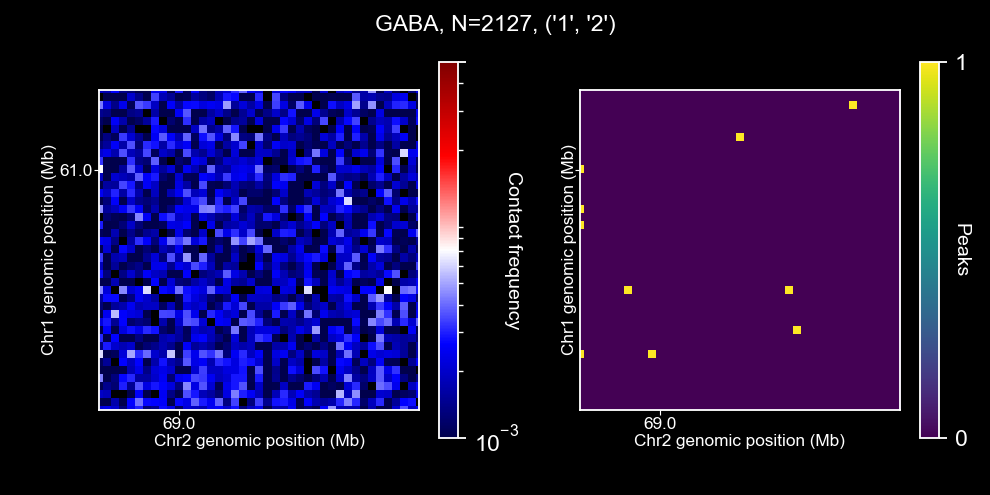

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220711-Figures\LongRangeContacts\LongRangeContact_GABA_1-2.png


In [211]:
from scipy import ndimage

make_plot = True
#_key = 'Oligo'
for _key in contact_dict:

    sel_feature = ('1', '2')
    #sel_feature = 'cis_1'
    _contact_mat = contact_dict[_key][sel_feature]
    mean_kernel = np.ones([3,3]) * 1/9
    peak_map = np.log(_contact_mat / ndimage.convolve(_contact_mat, mean_kernel, mode='nearest')) / np.log(2)

    _ixs, _iys = np.where(peak_map >= peak_log_th )
    kept_tuples = []

    if 'cis' in sel_feature:
        c1, c2 = sel_feature.split('cis_')[1], sel_feature.split('cis_')[1]
        vmin, vmax = 4e-3, 2e-1
        peak_log_th = 0.8
        peak_neighbor_ratio_th = 1.25
        peak_noise_std_th = 5
    else:
        c1, c2 = sel_feature
        vmin, vmax = 1e-3, 5e-2
        peak_log_th = 1
        peak_neighbor_ratio_th = 2
        peak_noise_std_th = 3

    for _ix, _iy in zip(_ixs, _iys):
        if 'cis' in sel_feature and _ix == _iy:
            continue
        _peak_val = _contact_mat[_ix, _iy]
        _neighbor_vals = get_2d_neighbors(_ix, _iy, _contact_mat, 1)

        _ratio_keep_flag = _peak_val / np.max(_neighbor_vals) > peak_neighbor_ratio_th
        _noise_keep_flag = (_peak_val - np.mean(_neighbor_vals)) / np.std(_neighbor_vals) > peak_noise_std_th
        print(_ix, _iy, _peak_val / np.max(_neighbor_vals), (_peak_val - np.mean(_neighbor_vals)) / np.std(_neighbor_vals), _peak_val)
        if _ratio_keep_flag and _noise_keep_flag:
            kept_tuples.append((_ix, _iy))

    _kept_ixs, _kept_iys = tuple(np.array(kept_tuples).transpose())
    _kept_mask = np.zeros_like(_contact_mat)
    _kept_mask[_kept_ixs, _kept_iys] = 1

    c1_codebook = codebook.loc[codebook['chr']==str(c1)].sort_values('chr_order')
    c2_codebook = codebook.loc[codebook['chr']==str(c2)].sort_values('chr_order')
    c1_ticks = np.arange(0, len(c1_codebook), 50)
    c2_ticks = np.arange(0, len(c2_codebook), 50)
    c1_starts = np.round([int(_name.split(':')[1].split('-')[0])/1e6 for _name in c1_codebook['name'] ])
    c2_starts = np.round([int(_name.split(':')[1].split('-')[0])/1e6 for _name in c2_codebook['name'] ])


    if make_plot:
        fig, axes = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True, dpi=150)
        pf_contact = axes[0].imshow(_contact_mat, cmap='seismic', norm=LogNorm(vmin=vmin, vmax=vmax))
        pf_peak = axes[1].imshow(_kept_mask)

        cbar = plt.colorbar(pf_contact, ax=axes[0], shrink=0.8, ticks=[vmin, vmax])
        cbar.set_label('Contact frequency', 
                       fontsize=_font_size+1, labelpad=1, rotation=270)
        cbar = plt.colorbar(pf_peak, ax=axes[1], shrink=0.8, ticks=[0,1])
        cbar.set_label('Peaks', 
                       fontsize=_font_size+1, labelpad=1, rotation=270)
        # get ticks
        axes[0].set_yticks(c1_ticks)
        axes[0].set_yticklabels(c1_starts[c1_ticks])
        axes[0].set_ylabel(f"Chr{c1} genomic position (Mb)", fontsize=_font_size, labelpad=1)
        axes[0].set_xticks(c2_ticks)
        axes[0].set_xticklabels(c2_starts[c2_ticks])
        axes[0].set_xlabel(f"Chr{c2} genomic position (Mb)", fontsize=_font_size, labelpad=1)
        axes[0].tick_params('both', labelsize=_font_size, 
                        width=_ticklabel_width, length=_ticklabel_size,
                        pad=1, ) # remove bottom ticklabels for ax1
        axes[1].set_ylabel(f"Chr{c1} genomic position (Mb)", fontsize=_font_size, labelpad=1)
        axes[1].set_xlabel(f"Chr{c2} genomic position (Mb)", fontsize=_font_size, labelpad=1)
        axes[1].tick_params('both', labelsize=_font_size, 
                        width=_ticklabel_width, length=_ticklabel_size,
                        pad=1, ) # remove bottom ticklabels for ax1
        fig.subplots_adjust(wspace=0.2, hspace=0.2, left=0.1, right=0.99, top=0.97, bottom=0.02)
        fig.suptitle(f"{_key}, N={count_dict[_key]}, {sel_feature}", fontsize=10, y=0.97)
        saveFigFile = os.path.join(contact_figure_folder, f'LongRangeContact_{_key}_{c1}-{c2}.png')
        print(saveFigFile)
        #fig.savefig(saveFigFile, transparent=True, dpi=300)
        
        axes[0].set_xlim([40,80])
        axes[0].set_ylim([80,40])
        fig.savefig(os.path.join(contact_figure_folder, f'cropped_LongRangeContact_{_key}_{c1}-{c2}.png'), transparent=True, dpi=300)
        
        

In [217]:
def Chr2ZxysList_2_Dists_by_key(chr_2_zxys_list, 
                                      _c1, _c2, codebook_df,
                                      verbose=False):
    _out_dist_dict = {}
    if _c1 != _c2:
        _out_dist_dict[(_c1,_c2)] = []
    else:
        _out_dist_dict[f"cis_{_c1}"] = []
        _out_dist_dict[f"trans_{_c1}"] = []
    for _chr_2_zxys in chr_2_zxys_list:
        # skip if not all info exists
        if _c1 not in _chr_2_zxys or _c2 not in _chr_2_zxys or _chr_2_zxys[_c1] is None or _chr_2_zxys[_c2] is None:
            continue
        else:
            # if not from the same chr label, calcluate trans-chr with cdist
            if _c1 != _c2:
                for _zxys1 in _chr_2_zxys[_c1]:
                    for _zxys2 in _chr_2_zxys[_c2]:
                        _out_dist_dict[(_c1,_c2)].append(cdist(_zxys1, _zxys2))
            # if from the same chr label, calculate both cis and trans
            else:
                # cis
                _out_dist_dict[f"cis_{_c1}"].extend([squareform(pdist(_zxys)) for _zxys in _chr_2_zxys[_c1]])
                # trans
                if len(_chr_2_zxys[_c1]) > 1:
                    # loop through permutations
                    for _i1, _i2 in permutations(np.arange(len(_chr_2_zxys[_c1])), 2):
                        _out_dist_dict[f"trans_{_c1}"].append(
                            cdist(_chr_2_zxys[_c1][_i1], _chr_2_zxys[_c1][_i2])
                        )
    for _key in _out_dist_dict:
        print(_key, len(_out_dist_dict[_key]))
    return _out_dist_dict

In [ ]:
dist_dict = Chr2ZxysList_2_Dists_by_key(Maj)

In [208]:
c1,c2

('1', '1')

In [215]:
_kept_ixs, _kept_iys

(array([  0,   2,   5,   8,   8,  24,  26,  26,  26,  30,  31,  31,  36,
         37,  37,  39,  42,  42,  46,  50,  50,  50,  50,  55,  55,  55,
         55,  55,  57,  65,  65,  65,  67,  70,  70,  73,  73,  73,  73,
         73,  76,  79,  84,  84,  87,  87,  93, 100, 101, 102, 106, 107,
        112, 112, 114, 114, 117, 119, 121, 129, 133, 134, 134, 134, 135,
        139, 141, 144], dtype=int64),
 array([ 27, 112,  45,  19, 106,  44,  46,  92, 127, 138,  73,  75,  19,
        100, 139,  99,  74,  88,  60,  40, 106, 123, 138,  16,  19,  40,
        106, 127,  40,   8,  46,  66, 133,  67,  95,  19,  40,  49, 106,
        138,  19, 109,  40, 127,  40, 138,  94,  88,  42,  77,  85, 122,
         14,  95,  40, 138,  32, 122,  88,  30, 116,  56,  75,  95,  84,
          9,  84,  92], dtype=int64))

In [212]:
np.unique(_kept_ixs, return_counts=True)

(array([  0,   2,   5,   8,  24,  26,  30,  31,  36,  37,  39,  42,  46,
         50,  55,  57,  65,  67,  70,  73,  76,  79,  84,  87,  93, 100,
        101, 102, 106, 107, 112, 114, 117, 119, 121, 129, 133, 134, 135,
        139, 141, 144], dtype=int64),
 array([1, 1, 1, 2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 4, 5, 1, 3, 1, 2, 5, 1, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1],
       dtype=int64))

In [213]:
np.unique(_kept_iys, return_counts=True)

(array([  8,   9,  14,  16,  19,  27,  30,  32,  40,  42,  44,  45,  46,
         49,  56,  60,  66,  67,  73,  74,  75,  77,  84,  85,  88,  92,
         94,  95,  99, 100, 106, 109, 112, 116, 122, 123, 127, 133, 138,
        139], dtype=int64),
 array([1, 1, 1, 1, 5, 1, 1, 1, 7, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 3, 2, 1, 3, 1, 1, 4, 1, 1, 1, 2, 1, 3, 1, 5, 1], dtype=int64))

<IPython.core.display.Javascript object>


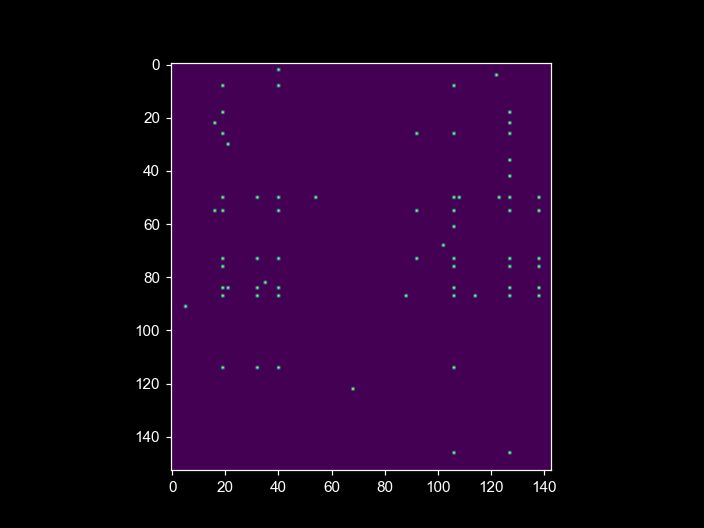

In [73]:
_neighbor_vals

array([0.00112337, 0.00321677, 0.00226851, 0.00322581, 0.00231006,
       0.00213155, 0.00252124, 0.00177853])

In [74]:
_contact_mat[_ix, _iy]

0.006060606060606061

In [333]:
test_im = np.zeros([10,100,100])

<IPython.core.display.Javascript object>


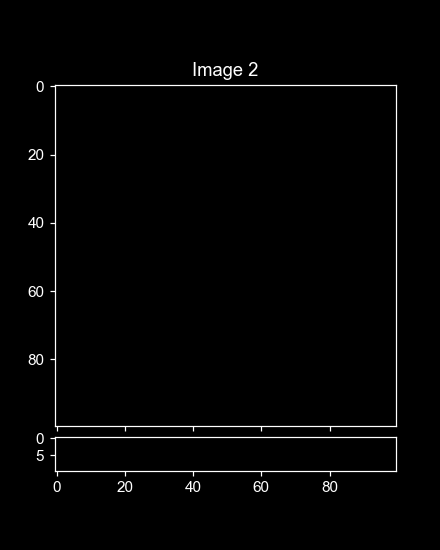

In [339]:
_vis_cls = visual_tools.imshow_mark_3d_v2([test_im, test_im])

In [340]:
_vis_cls.coords

[(43.84659896358367, 36.78098572873641, 4.5),
 (54.49176025390625, 18.42321536268298, 4.5)]